# Visualize Heat Flux Feedback Variables


Test Test

In [75]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import glob
import sys

from cartopy.util import add_cyclic_point



In [76]:
# Import visualization modules
sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")
from amv import proc,viz

In [77]:
# Indicate variable and crop options
vname       = "V" 
datpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/01_hfdamping/atmvar/"
datpath_var = datpath + "%s/" % vname

# Historical Crop
hstart      = '1970-01-01' 
hend        = '1999-12-31'

# RCP85 Crop
rstart      = '2070-01-01'
rend        = '2099-12-31'

# Plotting Options
figpath       = "/home/glliu/02_Figures/01_WeeklyMeetings/20220817/"
bboxplot_glob = [-180,180,-65,75]
proj          = ccrs.PlateCarree(central_longitude=0)
proc.makedir(figpath)

/home/glliu/02_Figures/01_WeeklyMeetings/20220817/ was found!


In [78]:
# Try globbing all files (test, not actually used)
nclist = glob.glob(datpath_var + "*.nc")
print(len(nclist))

ncs_htr   = [f for f in nclist if "htr" in f]
ncs_r85   = [f for f in nclist if "rcp85" in f]

ncs_htr.sort()
ncs_r85.sort()

print("Found %i files in htr" % len(ncs_htr))
#print(*ncs_htr,sep="\n")
print("Found %i files in rcp85" % len(ncs_r85))

82
Found 42 files in htr
Found 40 files in rcp85


In [79]:
%%time
# More explicitly read in variables

e = 0

htr_all = []
r85_all = []
for e in range(40):
    
    # Open Dataset
    ncname_htr = "%s%sdiff_htr_1920to2006_ens%02i.nc" % (datpath_var,vname,e+1)
    ncname_r85 = "%s%sdiff_rcp85_2006to2100_ens%02i.nc" % (datpath_var,vname,e+1)
    #print(ncname_htr)
    #print(ncname_r85)
    ds_htr     = xr.open_dataset(ncname_htr)
    ds_r85     = xr.open_dataset(ncname_r85)
    
    

    # Get the Data Array
    ds_htr     = ds_htr.sel(time=slice(hstart,hend))
    ds_r85     = ds_r85.sel(time=slice(rstart,rend))
    
    # Fix latitude
    # Small roundoff error in latitude...
    if e > 0:
        dsloop = [ds_htr,ds_r85]
        dsloop_new = []
        for dsna in dsloop:
            if np.any(~(dsna.lat.values == htr_all[0].lat.values)):
                dsna = dsna.assign_coords(lat=htr_all[0].lat.values)
                print("\tReassigning latitude values for ENS%i"% (e+1))
            dsloop_new.append(dsna)
        ds_htr,ds_r85 = dsloop_new
    
    # Append to list
    htr_all.append(ds_htr)
    r85_all.append(ds_r85)

# # Read out as NumPy Array
# hvar       = ds_htr[vname].values
# rvar       = ds_r85[vname].values

# if e == 0:
#     var_htr = np.zeros()
#     var_r85 = np.zeros() * np.nan
ds_r85

	Reassigning latitude values for ENS36
	Reassigning latitude values for ENS36
	Reassigning latitude values for ENS37
	Reassigning latitude values for ENS37
	Reassigning latitude values for ENS38
	Reassigning latitude values for ENS38
	Reassigning latitude values for ENS39
	Reassigning latitude values for ENS39
	Reassigning latitude values for ENS40
	Reassigning latitude values for ENS40
CPU times: user 1.45 s, sys: 127 ms, total: 1.57 s
Wall time: 2.17 s


<xarray.Dataset>
Dimensions:  (time: 360, lat: 192, lon: 288)
Coordinates:
  * time     (time) object 2070-01-01 00:00:00 ... 2099-12-01 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    V        (time, lat, lon) float32 ...

In [80]:
%%time
# Concatenate along new dimension, ensemble
htr_all = xr.concat(htr_all,dim='ensemble')
r85_all = xr.concat(r85_all,dim='ensemble')

r85_all

CPU times: user 50.6 s, sys: 19.1 s, total: 1min 9s
Wall time: 1min 15s


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 360, ensemble: 40)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2070-01-01 00:00:00 ... 2099-12-01 00:00:00
Dimensions without coordinates: ensemble
Data variables:
    V        (ensemble, time, lat, lon) float32 -0.5215 -0.5873 ... -0.9126

In [81]:
htr_all

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 360, ensemble: 40)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1970-01-01 00:00:00 ... 1999-12-01 00:00:00
Dimensions without coordinates: ensemble
Data variables:
    V        (ensemble, time, lat, lon) float32 0.1305 0.05007 ... -1.061 -1.114

In [82]:
%%time
# Compute average vertical difference in selected period
htr_avg_time = htr_all.mean('time')
r85_avg_time = r85_all.mean('time')

# Compute ensemble average of this
htr_ensavg = htr_avg_time.mean('ensemble')
r85_ensavg = r85_avg_time.mean('ensemble')

CPU times: user 10.7 s, sys: 10.5 s, total: 21.3 s
Wall time: 21.3 s


In [83]:
htr_ensavg

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    V        (lat, lon) float32 -1.485 -1.624 -1.762 ... -0.9086 -0.9154 -0.9218

In [84]:
%%time

# Save the output
savename_htr = "%s%sdiff_%s_%sto%s_ensavg.nc" % (datpath,vname,"htr",hstart[:4],hend[:4])
htr_ensavg.to_netcdf(savename_htr,encoding={vname: {'zlib': True}})

savename_r85 = "%s%sdiff_%s_%sto%s_ensavg.nc" % (datpath,vname,"rcp85",rstart[:4],rend[:4])
r85_ensavg.to_netcdf(savename_r85,encoding={vname: {'zlib': True}})

print("Saved %s \n %s" % (savename_htr,savename_r85))

Saved /stormtrack/data3/glliu/01_Data/02_AMV_Project/01_hfdamping/atmvar/Vdiff_htr_1970to1999_ensavg.nc 
 /stormtrack/data3/glliu/01_Data/02_AMV_Project/01_hfdamping/atmvar/Vdiff_rcp85_2070to2099_ensavg.nc
CPU times: user 53.5 ms, sys: 4.81 ms, total: 58.3 ms
Wall time: 74.4 ms


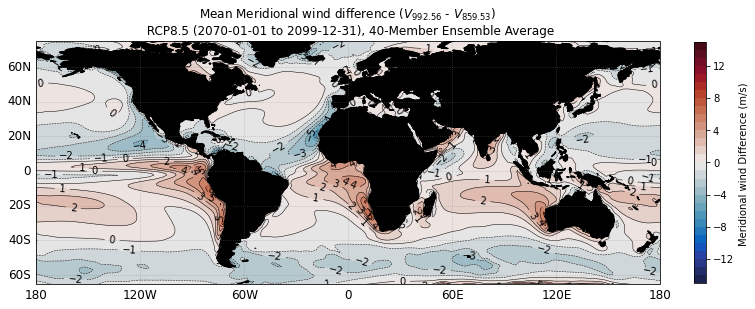

In [85]:
# Plot Vertical Gradients for selected period

expnum     = 1 # 0=Historical, 1=RCP8.5, 2=RCP-HTR

# Choose Variable to plot
if expnum == 0:
    plotvar  = htr_ensavg[vname]
    tstart   = hstart
    tend     = hend
    expname = "Historical"
elif expnum == 1:
    plotvar  = r85_ensavg[vname]
    tstart   = rstart
    tend     = rend
    expname = "RCP8.5"
elif expnum == 2:
    plotvar =  r85_ensavg[vname] - htr_ensavg[vname]
    tstart   = ""
    tend     = ""
    expname  = "RCP8.5 - Historical"
    
# Other Plotting Options
"""
Current values used ... 
Variable | Single Period | Difference
U | np.arange(-10,11,1) | np.arange(-2,2.25,.25)
Q | np.arange(-0.012,0.013,0.001) | (-0.003,0.00325,0.00025)
V | np.arange(-10,11,1) | np.arange(-2,2.25,.25)
T | np.arange(-12,13,1) | np.arange(-5,5.5,.5)
"""
use_pcolor = False
clvls      = np.arange(-15,16,1)#None# np.arange(-10,11,1)#np.arange(-2,2.25,.25)# None or provide values
cmap       = 'cmo.balance'

# Get first ds for lat/lon/attributes
ds         = ds_htr[vname]


vdiff_str = "$%s_{%.2f}$ - $%s_{%.2f}$" % (vname,ds.attrs['z_sfc'],
                                              vname,ds.attrs['z_ref'])


if expnum < 2:
    title = "Mean %s difference (%s) \n %s (%s to %s), 40-Member Ensemble Average" % (
                                                                      ds.attrs['long_name'],vdiff_str,
                                                                      expname,tstart,tend)
else:
    
    title = "Mean %s difference (%s) \n %s, 40-Member Ensemble Average" % (
                                                                      ds.attrs['long_name'],vdiff_str,
                                                                      expname)

fig,ax = plt.subplots(1,1,figsize=(12,6.5),facecolor='white',
                       subplot_kw={'projection':proj})

#pcm = ds_diff.mean('time').plot(ax=ax)
if use_pcolor:
    if clvls is None:
        pcm = ax.pcolormesh(ds.lon,ds.lat,plotvar,cmap=cmap,transform=proj)
    else:
        pcm = ax.pcolormesh(ds.lon,ds.lat,plotvar,vmin=clvls[0],vmax=clvls[-1],cmap=cmap,transform=proj)
else:
    
    data, lon = add_cyclic_point(plotvar, coord=ds.lon)
    
    if clvls is None:
        pcm = ax.contourf(lon,ds.lat,data,cmap=cmap,transform=proj)
        
    else:
        pcm = ax.contourf(lon,ds.lat,data,levels=clvls,cmap=cmap,transform=proj)
        cl  = ax.contour(lon,ds.lat,data,levels=clvls,colors="k",linewidths=0.5,transform=proj)
        ax.clabel(cl,colors="k",)


ax = viz.add_coast_grid(ax,proj=proj,bbox=bboxplot_glob,
                        fill_color='k',ignore_error=True)
ax.set_title(title)
cb = fig.colorbar(pcm,ax=ax,fraction=0.018)
cb.set_label("%s Difference (%s) " % (ds.attrs['long_name'],ds.attrs['units']))
plt.savefig("%s%sdiff_AnnEnsAvg_%s_%sto%s.png" % (figpath,vname,expname.replace(" ",""),tstart,tend),dpi=200,bbox_inches='tight')
